## Building a live Face Recognition System

We use opencv2 and sklearn for the same.

In [1]:
import cv2
import cv2.face
print(cv2.__version__)
import numpy as np
from matplotlib import pyplot as plt
import os
import math
from IPython.display import clear_output

3.1.0


In [2]:
#TAKING AN IMAGE
webcam = cv2.VideoCapture(0) # create a webcam object
ret, frame = webcam.read()
print(ret) #returns if it reads it or not
webcam.release() #to close the cam

True


If not using jupyter notebook
```python

#Open a new thread to manage external cv interaction
cv2.startWindowThread() 
#create a window holder 
cv2.namedWindow("Tut", WINDOW_NORMAL)
cv2.imshow("Tut", frame)
cv2.waitKey()
cv2.destroyAllWindows()

<type 'numpy.ndarray'>


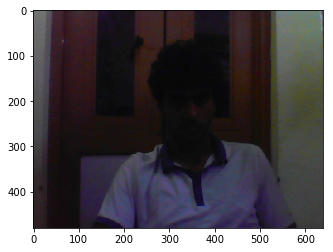

In [3]:
print type(frame)
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)#OpenCV - BGR format, matplotlib -RGB
plt.imshow(frame)
plt.show() 

        

#### Function to display image using numpy :

In [4]:
# Define a function to display image using numpy
def plt_showImage(image, title=""):
    if len(image.shape) == 3   : # 3 channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()

#### Displaying a Video

In [5]:
from IPython.display import clear_output
#VIDEO 
webcam = cv2.VideoCapture(0)
print webcam.isOpened()
try:
    while True:
        _, frame = webcam.read()
        plt_showImage(frame)
        clear_output(wait=True) # wait for the new op
except KeyboardInterrupt:
        print 'Interrupted'
webcam.release()

Interrupted


## Using Haar Features
<img src="4.png"></img>

<img src="5.png" align="left"></img>
<img src="3.png" align="left"></img>


### We use
1. Integral Image
2. Adaboost
  solution Cascading (38 Stages in OpenCV)
  
 * haarcascade_frontalface

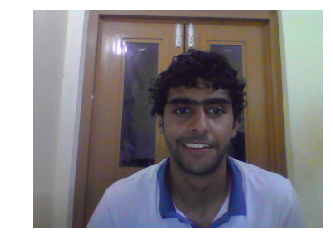

In [12]:
webcam = cv2.VideoCapture(0)
_,frame = webcam.read()
webcam.release()
plt_showImage(frame)

#### We find the biggest face in an image and return its position and dimensions (top, left, width and height).
         - param image: the image in which to detect faces
         - type image: numpy array
         - return: top, left, width and height of the rectangle around the face
         - rtype: tuple of length 4
         
####  We declare the FaceDetect function using haarcascade_frontalface_alt.xml :

In [6]:
def FaceDetect(frame):
    detector = cv2.CascadeClassifier("/home/zam/anaconda2/pkgs/opencv-3.1.0-np111py27_1/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml")
    scale_factor=1.2
    min_neighbors=5
    min_size=(30,30)
    biggest_only=True

    flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
                 cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
                  cv2.CASCADE_SCALE_IMAGE

    faces_coord = detector.detectMultiScale(frame,
                                             scaleFactor=scale_factor,
                                             minNeighbors=min_neighbors,
                                             minSize=min_size,flags=flags)
    #print "Type:" + str(type(faces_coord))
    #print faces_coord
    #print "Length:" + str(len(faces_coord))                                       
    return faces_coord



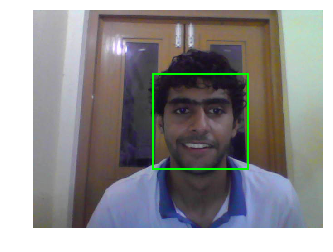

In [14]:
for (x , y , w, h) in FaceDetect(frame):
    cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),3)
plt_showImage(frame)


To make our work easy lets define a Camera class object :



In [7]:
class Camera(object):
    def initialize(cam , index = 0):
        cam.video= cv2.VideoCapture(index)
        cam.index = index
        print cam.video.isOpened()
        
    def close(cam):
        cam.video.release()
    
    def read(cam):
        _, frame = cam.video.read()
        return frame
        
        

### Detecting Faces in a live video : 

In [8]:
from IPython.display import clear_output
webcam = Camera()
webcam.initialize()
    
try:
    while True:
        frame = webcam.read()
        faces_coordinates=FaceDetect(frame)
        for (x , y , w, h) in faces_coordinates:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),3)
        plt_showImage(frame)
        clear_output(wait = True)
except KeyboardInterrupt:
        print 'Interrupted'
webcam.close()        



Interrupted


## Now we move on to Collecting data for our database

1. We first need to normalize all the pictures.
2. Collect Pictures of a person and label them with their name.
3. Train our machine learnin algorithm with these
4. Test against new data.

### Cut Face Function :

#### cut_Face()

In [9]:
#Step 1. Cutting the face
def cut_Face(frame, faces_coord):
    faces = []
    
    for (x ,y , w, h) in faces_coord:
        w_n= int(0.2 * w/2)
        faces.append(frame[y: y+h, x+w_n: x+w-w_n]) 
    return faces

### Normalize Intensity Function :

#### normalize_intensity()

In [10]:
# Normailze Image Function
# If colored , convert to Grayscale and then store it in the array frames_norm
# This increases the contast and improves the featuyres
def normalize_intensity(frames):
    frames_norm=[]
    for frame in frames:
        is_color = len(frame.shape) == 3
        if is_color: #if BGR
            frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames_norm.append(cv2.equalizeHist(frame))
    return frames_norm

### Resize Face Function : 

#### resize_Face()

In [11]:
def resize_Face(frames, size =(50,50)):
    frames_resize = []
    for frame in frames :
        if frame.shape < size:
            frame_resize = cv2.resize(frame, size , interpolation = cv2.INTER_AREA)
        else:
            frame_resize = cv2.resize(frame, size , interpolation = cv2.INTER_CUBIC)
        
        frames_resize.append(frame_resize)
    return frames_resize

### Now we implement cutting the face

The normalize function used above helps us increase the contrast and improve features for face detection.

In [12]:
webcam = Camera()
webcam.initialize()
try:
    while True:
        frame = webcam.read()
        faces_coord = FaceDetect(frame)
        if len(faces_coord): # if face detected
            faces=cut_Face(frame, faces_coord)
            plt_showImage(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
        print 'Interrupted'
webcam.close() 


Interrupted


## Comparing Pixel Intensities :

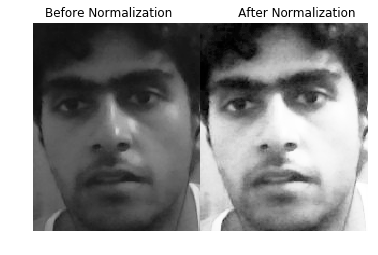

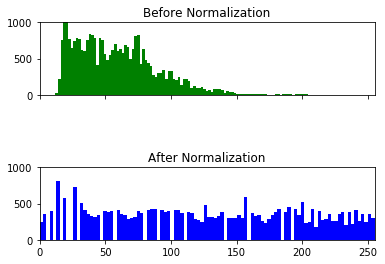

In [132]:
faces_bw=cv2.cvtColor(faces[0], cv2.COLOR_BGR2GRAY)
faces_bw_norm=cv2.equalizeHist(faces_bw)
plt_showImage(np.hstack((faces_bw, faces_bw_norm)), "Before Normalization                 After Normalization" )

f, (p1, p2 )= plt.subplots(2, sharex=True , sharey=True)
p1.hist(faces_bw.flatten(),100 ,color = 'g')
p2.hist(faces_bw_norm.flatten(),100 ,color = 'b')
p1.set_xlim([0,255])
p1.set_ylim([0,1000])
p2.set_xlim([0,255])
p2.set_ylim([0,1000])
p2.set_title("After Normalization")
p1.set_title("Before Normalization")
f.subplots_adjust(hspace=1)
plt.show()

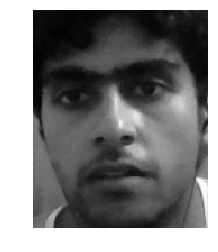

In [133]:
faces_bw=cv2.cvtColor(faces[0], cv2.COLOR_BGR2GRAY)
plt_showImage(faces_bw)
face=normalize_Frame(faces_bw)

## Together it becomes :

In [13]:
webcam = Camera()
webcam.initialize()
try:
    while True:
        frame = webcam.read()
        faces_coord = FaceDetect(frame)
        if len(faces_coord):
            faces = cut_Face(frame,faces_coord)
            faces = normalize_intensity(faces)
            faces = resize_Face(faces)
            plt_showImage(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
        print 'Interrupted'
webcam.close() 



Interrupted


 ### Let us create and overall normalize function now 
 #### normalize_Faces()
 #### rectangle_box()



In [14]:
def normalize_Faces(frame, faces_coord):
    faces = cut_Face(frame, faces_coord)
    faces = normalize_intensity(faces)
    faces = resize_Face(faces)
    return faces

def rectangle_box(frame, rect_coord):
    for (x,y,w,h) in rect_coord:
        w_n= int(0.2 * w/2)
        cv2.rectangle(frame,(x + w_n,y),(x+w-w_n,y+h),(0,255,0),3)
        

# Build Dataset

Our next job is to build a database for our machine learning algorithm.

Each folder will contain 21 pictures of a person, the name of the folder(i. the name of the person) specifies the label or output for that particular set.

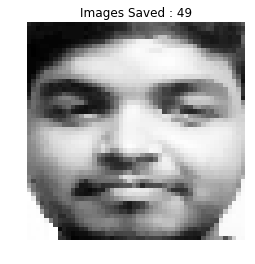

In [88]:
webcam = Camera()
webcam.initialize()
folder = "/home/zam/Documents/Notebooks/people/" + raw_input('Person: ').lower() #name of the person aka label
if not os.path.exists(folder):
    os.mkdir(folder)  #creates direc named after the person
    counter= 0;
    timer = 0;
    while counter < 50 :
        frame = webcam.read()
        faces_coord=FaceDetect(frame)
        if len(faces_coord) and timer % 700 == 50:
            faces = normalize_Faces(frame, faces_coord)
            cv2.imwrite(folder + '/' + str(counter) + '.jpg', faces[0]) # saving as numbered jpeg
            plt_showImage(faces[0], "Images Saved : " + str(counter))
            clear_output(wait = True)
            counter += 1
        rectangle_box(frame, faces_coord)
        timer+=50
else:
    print "This name already exists"
webcam.close()




#### We now get our dataset 



In [62]:
def collect_Dataset():
    images = []
    labels = []
    labels_dic = {}
    people = [person for person in os.listdir("/home/zam/Documents/Notebooks/people/")]
    for i, person in enumerate(people):
        labels_dic[i] = person
        for image in os.listdir("/home/zam/Documents/Notebooks/people/" + person):
            images.append(cv2.imread("/home/zam/Documents/Notebooks/people/" + person + '/' + image, 0).flatten())#flattens 2-D numpy array to 1-D
            labels.append(i)
    return (images, np.array(labels), labels_dic)

## We use SVM from sklearn package 

In [63]:
from sklearn import svm


In [89]:
images, labels, labels_dic = collect_Dataset()
clf=svm.SVC( gamma=0.0000001, C=100)  # MATH HERE       save - g = 0.0000001, c = 100
#clf=svm.SVC( C = 100, gamma = 10)  # MATH HERE
x= images
y= labels
clf.fit(x,y)
#print len(x)
#plt_showImage(x[165])
#print labels[165]
#print "{0: 'allwin', 1: 'krishnan', 2: 'sidhant', 3: 'vishnu', 4: 'zaman', 5: 'rinku', 6: 'umang'}"


  

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
C_mat=[0.00000001, 0.0003, 0.003, 0.03 ,0.3, 3 ,30, 300, 3000];
gamma_mat=[0.00001, 0.0001, 0.001,0.01, 0.1, 1 ,10, 100 , 10000 , 100000000];
for i in range (0,len(C_mat)):
        for j in range (0,len(gamma_mat)):
                clf=svm.SVC( C = C_mat[i], gamma = gamma_mat[j]) 
                clf.fit(x,y)
                img = get_Input("/home/zam/Documents/Notebooks/verify/asd/1.jpg")
                print "1 : "
                print labels_dic[np.asscalar(clf.predict(img))]
                img2= get_Input("/home/zam/Documents/Notebooks/verify/asd/5.jpg")
                print "2 : " 
                print labels_dic[np.asscalar(clf.predict(img2))]

#### Defining get new Image function as we need input to be in GRAYSCALE

In [71]:
def get_Input(imgPath):
    img=cv2.imread(imgPath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    plt_showImage(img)
    img = img.ravel()
    return img

#### In the following code we check if our algorithm is working correctly on a new data

{0: 'allwin', 1: 'sidhant', 2: 'vishnu', 3: 'mayank', 4: 'zaman', 5: 'rinku', 6: 'umang'}


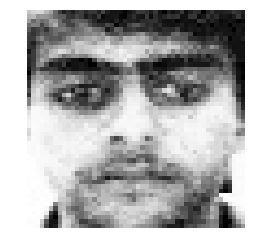

Prediction :
zaman
Expected :
zaman


/home/zam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [91]:
print labels_dic 

img = get_Input("/home/zam/Documents/Notebooks/verify/0.jpg")

print "Prediction :"
print labels_dic[np.asscalar(clf.predict(img))] #np.asscalar(np.array([])) converts numpy array to scalar

print "Expected :"
print labels_dic[4]

In [92]:
webcam = Camera()
webcam.initialize()
try:
    while True:
        frame = webcam.read()
        faces_coord = FaceDetect(frame)
        if len(faces_coord):
            faces = cut_Face(frame,faces_coord)
            faces = normalize_intensity(faces)
            faces = resize_Face(faces)
            face =  faces[0].ravel()
            a= labels_dic[np.asscalar(clf.predict(face))]
            print labels_dic[np.asscalar(clf.predict(face))]
            rectangle_box(frame,faces_coord)
            for (x , y , w, h) in FaceDetect(frame):
                cv2.putText(frame, a , (x,y+h+h/18), cv2.FONT_HERSHEY_SIMPLEX , 2, (255,255,255),3) #Display Name
            plt_showImage(frame)
            clear_output(wait = True)
except KeyboardInterrupt:
        print 'Interrupted'
webcam.close() 

Interrupted


True


/home/zam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/zam/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


zaman


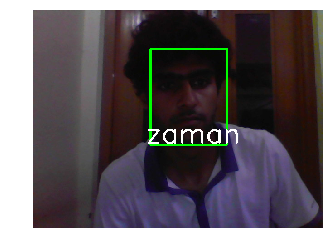

In [96]:
webcam = Camera()
webcam.initialize()
frame = webcam.read()
faces_coord = FaceDetect(frame)
if len(faces_coord):
    faces = cut_Face(frame,faces_coord)
    faces = normalize_intensity(faces)
    faces = resize_Face(faces)
    face =  faces[0].ravel()
    a= labels_dic[np.asscalar(clf.predict(face))]
    print labels_dic[np.asscalar(clf.predict(face))]
    rectangle_box(frame,faces_coord)
    for (x , y , w, h) in FaceDetect(frame):
        cv2.putText(frame, a , (x,y+h+h/18), cv2.FONT_HERSHEY_SIMPLEX , 2, (255,255,255),3) #Display Name
    plt_showImage(frame)
    clear_output(wait = True)
webcam.close() 